# __Analisis de Evasion de Clientes__

## Librerias

In [30]:
import pandas as pd
import numpy as np

In [31]:
import numexpr
print(numexpr.__version__)

2.11.0


## Extraccion de datos

### Importar Datos

In [32]:
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json'

df = pd.read_json(url)
df.head()

customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 'Fiber optic', 'OnlineSecu...   
3  {'InternetService': 'Fiber optic', 'OnlineSecu...   
4  {'InternetService': 'Fiber optic', 'OnlineSecu...   

                                             account  
0  {'Contract': 'One year', 'PaperlessBilling': '...  
1  {'Contract': 'Month-to-month', 'PaperlessBilli...  
2  {'Contract': 'Month-to-month', 'PaperlessBilli...  
3  {'Contract': 'Month-to-month', 'PaperlessBilli...  
4  {'Contract': 'Month-to-month', 'PaperlessBilli...

Como vemos, hay varias variables que contienen diccionarios en sus valores. Por tanto, debemos expandirlas

In [33]:
# expandir cada variable
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

In [34]:
# seleccionar variables no expandidas de df
df = df[['customerID', 'Churn']]

In [35]:
# unir todos los dfs en uno
df_exp = pd.concat([df, df_customer, df_phone, df_internet, df_account], axis=1)
df_exp.head(5)

customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... OnlineBackup  \
0          Yes            No             DSL  ...          Yes   
1          Yes           Yes             DSL  ...           No   
2          Yes            No     Fiber optic  ...           No   
3          Yes            No     Fiber optic  ...          Yes   
4          Yes            No     Fiber optic  ...           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         Yes         Yes              No        One year   
1               No          No          No             Yes  Month-to-month   
2              Yes          No          No              No  Month-to-month   
3              Yes          No         Yes             Yes  Month-to-month   
4               No         Yes         Yes              No  Month-to-month   

  PaperlessBilling     PaymentMethod Charges.Monthly  Charges.Total  
0              Yes      Mailed check            65.6          593.3  
1               No      Mailed check            59.9          542.4  
2              Yes  Electronic check            73.9         280.85  
3              Yes  Electronic check            98.0        1237.85  
4              Yes      Mailed check            83.9          267.4  

[5 rows x 21 columns]

### Contexto de los datos

Se tratan de datos de los clientes de una empresa cuya informacion de cada variable se interpreta como:

- _customerID_: número de identificación único de cada cliente
- _Churn_: si el cliente dejó o no la empresa
- _gender_: género (masculino y femenino)
- _SeniorCitizen_: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
- _Partner_: si el cliente tiene o no una pareja
- _Dependents_: si el cliente tiene o no dependientes
- _tenure_: meses de contrato del cliente
- _PhoneService_: suscripción al servicio telefónico
- _MultipleLines_: suscripción a más de una línea telefónica
- _InternetService_: suscripción a un proveedor de internet
- _OnlineSecurity_: suscripción adicional de seguridad en línea
- _OnlineBackup_: suscripción adicional de respaldo en línea
- _DeviceProtection_: suscripción adicional de protección del dispositivo
- _TechSupport_: suscripción adicional de soporte técnico, menor tiempo de espera
- _StreamingTV_: suscripción de televisión por cable
- _StreamingMovies_: suscripción de streaming de películas
- _Contract_: tipo de contrato
- _PaperlessBilling_: si el cliente prefiere recibir la factura en línea
- _PaymentMethod_: forma de pago
- _Charges.Monthly_: total de todos los servicios del cliente por mes
- _Charges.Total_: total gastado por el cliente

### Tipo de datos

In [36]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


> El conjunto de datos esta conformado por 7267 registros y 21 variables.

> Todas las variables tienen 7267 registros lo que indica la ausencia de valores faltantes.

> Las variables 'SeniorCitizen' y 'tenure' son de tipo entero, la variable 'Charges.Monthly' es de tipo float y el resto de variables son de tipo object.

> La variable 'Charges.Total' y 'Churn' en la practica son de tipo numerico. Sin embargo, Pandas las detecta de tipo object lo que sugiere un problema con la consistencia de los datos.

## Consistencia de los datos

### Registros duplicados

In [37]:
# verificar registros duplicados
df_exp.duplicated().sum()

0

> No hay registros duplicados en el dataframe.

### Tratar valores vacios

Verificamos los valores de 'Churn' y 'Charges.Total'

In [38]:
print('Charges.Total: ',df_exp['Charges.Total'].unique())
print('Churn: ',df_exp.Churn.unique())

Charges.Total:  ['593.3' '542.4' '280.85' ... '742.9' '4627.65' '3707.6']
Churn:  ['No' 'Yes' '']


> Los valores de _Churn_ y _Charges.Total_ presentan valores vacios por lo que procedemos a tratarlos

__Churn__

In [39]:
# registros con valores vacios en _Churn_
df_exp[df_exp['Churn'] == ''].shape

(224, 21)

> Hay 224 registros con valores vacios en _Churn_ lo que representa el 3% de los registros totales. Como la variable objetivo es _Churn_, sin esta informacion tales registros no aportan al analisis por tanto los eliminamos.

In [40]:
# elimina registros con Churn vacios
df_exp = df_exp[df_exp['Churn'] != '']
df_exp.shape

(7043, 21)

In [41]:
# verificar que Churn este libre de valores vacios
print(df_exp.Churn.unique())

['No' 'Yes']


__Charges.Total__

In [42]:
# registros vacios en Charges.Total
df_exp[df_exp['Charges.Total'] == ' ']

customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
975   1371-DWPAZ    No  Female              0     Yes        Yes       0   
1775  2520-SGTTA    No  Female              0     Yes        Yes       0   
1955  2775-SEFEE    No    Male              0      No        Yes       0   
2075  2923-ARZLG    No    Male              0     Yes        Yes       0   
2232  3115-CZMZD    No    Male              0      No        Yes       0   
2308  3213-VVOLG    No    Male              0     Yes        Yes       0   
2930  4075-WKNIU    No  Female              0     Yes        Yes       0   
3134  4367-NUYAO    No    Male              0     Yes        Yes       0   
3203  4472-LVYGI    No  Female              0     Yes        Yes       0   
4169  5709-LVOEQ    No  Female              0     Yes        Yes       0   
5599  7644-OMVMY    No    Male              0     Yes        Yes       0   

     PhoneService     MultipleLines InternetService  ...         OnlineBackup  \
975            No  No phone service             DSL  ...                  Yes   
1775          Yes                No              No  ...  No internet service   
1955          Yes               Yes             DSL  ...                  Yes   
2075          Yes                No              No  ...  No internet service   
2232          Yes                No              No  ...  No internet service   
2308          Yes               Yes              No  ...  No internet service   
2930          Yes               Yes             DSL  ...                  Yes   
3134          Yes               Yes              No  ...  No internet service   
3203           No  No phone service             DSL  ...                   No   
4169          Yes                No             DSL  ...                  Yes   
5599          Yes                No              No  ...  No internet service   

         DeviceProtection          TechSupport          StreamingTV  \
975                   Yes                  Yes                  Yes   
1775  No internet service  No internet service  No internet service   
1955                   No                  Yes                   No   
2075  No internet service  No internet service  No internet service   
2232  No internet service  No internet service  No internet service   
2308  No internet service  No internet service  No internet service   
2930                  Yes                  Yes                  Yes   
3134  No internet service  No internet service  No internet service   
3203                  Yes                  Yes                  Yes   
4169                  Yes                   No                  Yes   
5599  No internet service  No internet service  No internet service   

          StreamingMovies  Contract PaperlessBilling  \
975                    No  Two year               No   
1775  No internet service  Two year               No   
1955                   No  Two year              Yes   
2075  No internet service  One year              Yes   
2232  No internet service  Two year               No   
2308  No internet service  Two year               No   
2930                   No  Two year               No   
3134  No internet service  Two year               No   
3203                   No  Two year              Yes   
4169                  Yes  Two year               No   
5599  No internet service  Two year               No   

                  PaymentMethod Charges.Monthly  Charges.Total  
975     Credit card (automatic)           56.05                 
1775               Mailed check           20.00                 
1955  Bank transfer (automatic)           61.90                 
2075               Mailed check           19.70                 
2232               Mailed check           20.25                 
2308               Mailed check           25.35                 
2930               Mailed check           73.35                 
3134               Mailed check           25.75                 
3203  Ban

> Hay 11 registros con valores vacios en Charges.Total lo que representa el 0.1% de los registros totales. Al visualizarlos, nos damos cuenta que corresponden a clientes con contratos largos pero que no tienen ni el primer mes cumplido por lo que no aportan informacion relevante al estudio. Los eliminamos

In [43]:
# elimina registros con Charges.Total vacios
df_exp = df_exp[df_exp['Charges.Total'] != ' ']
df_exp.shape

(7032, 21)

In [44]:
# verificar que Churn este libre de valores vacios
print(df_exp['Charges.Total'].unique())

['593.3' '542.4' '280.85' ... '742.9' '4627.65' '3707.6']


In [45]:
import numpy as np 

# convertir a tipo entero
df_exp['Charges.Total'] = df_exp['Charges.Total'].astype(np.float64)

# verificar tipo
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   Churn             7032 non-null   object 
 2   gender            7032 non-null   object 
 3   SeniorCitizen     7032 non-null   int64  
 4   Partner           7032 non-null   object 
 5   Dependents        7032 non-null   object 
 6   tenure            7032 non-null   int64  
 7   PhoneService      7032 non-null   object 
 8   MultipleLines     7032 non-null   object 
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  Contract          7032 non-null   object 
 17  

### Columna de cuentas diarias

In [46]:
# crear columna de gasto diario de cada cliente
df_exp['Cuentas_Diarias'] = (df_exp['Charges.Monthly'])/(df_exp['tenure']*30)
df_exp.head()

customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0          Yes            No             DSL  ...               No   
1          Yes           Yes             DSL  ...               No   
2          Yes            No     Fiber optic  ...              Yes   
3          Yes            No     Fiber optic  ...              Yes   
4          Yes            No     Fiber optic  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes         Yes              No        One year              Yes   
1          No          No             Yes  Month-to-month               No   
2          No          No              No  Month-to-month              Yes   
3          No         Yes             Yes  Month-to-month              Yes   
4         Yes         Yes              No  Month-to-month              Yes   

      PaymentMethod Charges.Monthly Charges.Total  Cuentas_Diarias  
0      Mailed check            65.6        593.30         0.242963  
1      Mailed check            59.9        542.40         0.221852  
2  Electronic check            73.9        280.85         0.615833  
3  Electronic check            98.0       1237.85         0.251282  
4      Mailed check            83.9        267.40         0.932222  

[5 rows x 22 columns]

### Estandarizacion de los datos

Vamos a convertir los datos de las variables tipo object a enteros binarios donde sea posible y a renombrar las variables para una mejor comprension. Verifiquemos los valores unicos de cada variable.

In [47]:
# verificar valores de variables de tipo object
print('gender: ',df_exp.gender.unique())
print('SeniorCitizen: ',df_exp.SeniorCitizen.unique())
print('Partner: ',df_exp.Partner.unique())
print('Dependents: ',df_exp.Dependents.unique())
print('PhoneService: ',df_exp.PhoneService.unique())
print('MultipleLines: ',df_exp.MultipleLines.unique())
print('InternetService: ',df_exp.InternetService.unique())
print('OnlineSecurity: ',df_exp.OnlineSecurity.unique())
print('OnlineBackup: ',df_exp.OnlineBackup.unique())
print('DeviceProtection: ',df_exp.DeviceProtection.unique())
print('TechSupport: ',df_exp.TechSupport.unique())
print('StreamingTV: ',df_exp.StreamingTV.unique())
print('StreamingMovies: ',df_exp.StreamingMovies.unique())
print('Contract: ',df_exp.Contract.unique())
print('PaperlessBilling: ',df_exp.PaperlessBilling.unique())
print('PaymentMethod: ',df_exp.PaymentMethod.unique())
print('Charges.Total: ',df_exp['Charges.Total'].unique())
print('Churn: ',df_exp.Churn.unique())

gender:  ['Female' 'Male']
SeniorCitizen:  [0 1]
Partner:  ['Yes' 'No']
Dependents:  ['Yes' 'No']
PhoneService:  ['Yes' 'No']
MultipleLines:  ['No' 'Yes' 'No phone service']
InternetService:  ['DSL' 'Fiber optic' 'No']
OnlineSecurity:  ['No' 'Yes' 'No internet service']
OnlineBackup:  ['Yes' 'No' 'No internet service']
DeviceProtection:  ['No' 'Yes' 'No internet service']
TechSupport:  ['Yes' 'No' 'No internet service']
StreamingTV:  ['Yes' 'No' 'No internet service']
StreamingMovies:  ['No' 'Yes' 'No internet service']
Contract:  ['One year' 'Month-to-month' 'Two year']
PaperlessBilling:  ['Yes' 'No']
PaymentMethod:  ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
Charges.Total:  [ 593.3   542.4   280.85 ...  742.9  4627.65 3707.6 ]
Churn:  ['No' 'Yes']


__Cambiar nombre de las columnas__

In [48]:
nombres_nuevos = {
    'Churn': 'cancelacion',
    'gender': 'genero',
    'SeniorCitizen': 'jubilado',
    'Partner': 'en_pareja',
    'Dependents': 'dependientes',
    'tenure': 'meses_contrato',
    'PhoneService': 'servicio_telefonico',
    'MultipleLines': 'Multiples_lineas',
    'InternetService': 'servicio_internet',
    'OnlineSecurity': 'seguridad_online',
    'OnlineBackup': 'respaldo_online',
    'DeviceProtection': 'proteccion_dispositivo',
    'TechSupport': 'soporte_efectivo',
    'StreamingTV': 'Streaming_TV',
    'StreamingMovies': 'Streaming_peliculas',
    'Contract': 'tipo_contrato',
    'PaperlessBilling': 'facturacion_electronica',
    'Charges.Monthly': 'cuenta_mensual',
    'Charges.Total': 'cuentas_total',
    'PaymentMethod': 'metodo_pago',
    'Cuentas_Diarias': 'cuentas_diarias'
}

df_exp.rename(columns=nombres_nuevos, inplace=True)

__genero__

In [49]:
# renombrar valores de genero
df_exp['genero'] = df_exp['genero'].apply(lambda x: x.replace('Female', 'Femenino').replace('Male', 'Masculino'))
df_exp['genero'].unique()

array(['Femenino', 'Masculino'], dtype=object)

__jubilado__

In [50]:
df_exp['jubilado'] = df_exp['jubilado'].map({0:'No', 1:'Si'})
df_exp['jubilado'].unique()

array(['No', 'Si'], dtype=object)

__Churn__

In [51]:
# convertir valores de churn a binario
# 0:No esta con la empresa. 1: Sigue en la empresa
df_exp['cancelacion'] = df_exp['cancelacion'].replace({'Yes':'1', 'No':'0'}).astype(np.int64)
df_exp['cancelacion'].unique()

array([0, 1])

__Partner, Dependents, PhoneService y PaperlessBilling__

__en_pareja__

In [52]:
df_exp['en_pareja'] = df_exp['en_pareja'].map({'Yes':'Si', 'No':'No'})
df_exp.en_pareja.unique()

array(['Si', 'No'], dtype=object)

__dependientes, servicio_telefonico, facturacion_electronica__

In [53]:
lista = ['dependientes', 'servicio_telefonico', 'facturacion_electronica']

df_exp[lista] = df_exp[lista].replace({'Yes':'Si', 'No':'No'})
print(df_exp.servicio_telefonico.unique())
print(df_exp.dependientes.unique())
print(df_exp.facturacion_electronica.unique())



['Si' 'No']
['Si' 'No']
['Si' 'No']


Analicemos las variables que presentan mas de dos opciones: MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies y Contract

__Multiples_lineas__

In [56]:
# obtener valores de multipleline que no tienen servicio telefoncio
df_exp[df_exp['servicio_telefonico'] == 'No']['Multiples_lineas'].unique()

array(['No phone service'], dtype=object)

In [58]:
# obtener valores de multipleline que tienen servicio telefonico
df_exp[df_exp['servicio_telefonico'] == 'Si']['Multiples_lineas'].unique()

array(['No', 'Yes'], dtype=object)

> Observamos que los clientes que estan suscrito al servicio telefonico necesariamente tienen al menos 1 linea. Los que no estan suscrito, no tienen linea telefonica. Por tanto, esta variable no nos brinda informacion relevante, solo informacion redundante de 'PhoneService'. La omitimos del analisis.

In [ ]:
df_exp = df_exp.drop('Multiples_lineas', axis=1)

Tambien omitimos del analisis la variable customer_ID ya que son identificadores de los clientes que a nivel general no aporta informacion relevante.

In [59]:
df_exp = df_exp.drop('customerID', axis=1)

__servicio_internet__

In [60]:
df_exp['servicio_internet'] = df_exp['servicio_internet'].replace({'Fiber optic':'Fibra_optica'})
df_exp['servicio_internet'].unique()

array(['DSL', 'Fibra_optica', 'No'], dtype=object)

__seguridad_online__

In [ ]:
# obtener los valores de OnlineSecurity que no tienen servicio de internet
df_exp[df_exp['servicio_internet'] != 'No']['seguridad_online'].unique()

array(['No', 'Yes'], dtype=object)

Para este caso, hay clientes que a pesar de no contar con servicio de internet, estan suscritos a seguridad en linea. Podria agregar informacion valiosa al analisis.

__seguridad_online, respaldo_online, proteccion_dispositivo, soporte_efectivo, Streaming_tv, Streaming_peliculas__

In [67]:
lista = ['seguridad_online', 'respaldo_online', 'proteccion_dispositivo', 'soporte_efectivo', 'Streaming_TV', 'Streaming_peliculas']

df_exp[lista] = df_exp[lista].replace({'Yes': 'Si', 'No internet service': 'Sin internet'})
print(df_exp.seguridad_online.unique())
print(df_exp.respaldo_online.unique())
print(df_exp.proteccion_dispositivo.unique())
print(df_exp.soporte_efectivo.unique())
print(df_exp.Streaming_TV.unique())
print(df_exp.Streaming_peliculas.unique())

['No' 'Si' 'Sin internet']
['Si' 'No' 'Sin internet']
['No' 'Si' 'Sin internet']
['Si' 'No' 'Sin internet']
['Si' 'No' 'Sin internet']
['No' 'Si' 'Sin internet']


In [68]:
df_exp.head()

cancelacion     genero jubilado en_pareja dependientes  meses_contrato  \
0            0   Femenino       No        Si           Si               9   
1            0  Masculino       No        No           No               9   
2            1  Masculino       No        No           No               4   
3            1  Masculino       Si        Si           No              13   
4            1   Femenino       Si        Si           No               3   

  servicio_telefonico Multiples_lineas servicio_internet seguridad_online  \
0                  Si               No               DSL               No   
1                  Si              Yes               DSL               No   
2                  Si               No      Fibra_optica               No   
3                  Si               No      Fibra_optica               No   
4                  Si               No      Fibra_optica               No   

   ... proteccion_dispositivo soporte_efectivo Streaming_TV  \
0  ...                     No               Si           Si   
1  ...                     No               No           No   
2  ...                     Si               No           No   
3  ...                     Si               No           Si   
4  ...                     No               Si           Si   

  Streaming_peliculas   tipo_contrato facturacion_electronica  \
0                  No        One year                      Si   
1                  Si  Month-to-month                      No   
2                  No  Month-to-month                      Si   
3                  Si  Month-to-month                      Si   
4                  No  Month-to-month                      Si   

        metodo_pago cuenta_mensual  cuentas_total  cuentas_diarias  
0      Mailed check           65.6         593.30         0.242963  
1      Mailed check           59.9         542.40         0.221852  
2  Electronic check           73.9         280.85         0.615833  
3  Electronic check           98.0        1237.85         0.251282  
4      Mailed check           83.9         267.40         0.932222  

[5 rows x 21 columns]

In [69]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cancelacion              7032 non-null   int64  
 1   genero                   7032 non-null   object 
 2   jubilado                 7032 non-null   object 
 3   en_pareja                7032 non-null   object 
 4   dependientes             7032 non-null   object 
 5   meses_contrato           7032 non-null   int64  
 6   servicio_telefonico      7032 non-null   object 
 7   Multiples_lineas         7032 non-null   object 
 8   servicio_internet        7032 non-null   object 
 9   seguridad_online         7032 non-null   object 
 10  respaldo_online          7032 non-null   object 
 11  proteccion_dispositivo   7032 non-null   object 
 12  soporte_efectivo         7032 non-null   object 
 13  Streaming_TV             7032 non-null   object 
 14  Streaming_peliculas      7032

## Carga y Analisis

Resumen estadistico variables cualitativas 

In [ ]:
df_exp.select_dtypes(include=['object', 'category']).columns

Index(['genero', 'servicio_internet', 'seguridad_online', 'respaldo_online',
       'proteccion_dispositivo', 'soporte_efectivo', 'Streaming_TV',
       'Streaming_peliculas', 'tipo_contrato', 'metodo_pago'],
      dtype='object')

In [ ]:
var_categoricas = df_exp.select_dtypes(include=['object', 'category']).columns
var_categoricas.append('cancelacion','jubilado', 'en_pareja', 'dependientes', 'servicio_telefonico', 'facturacion_electronica')
df_exp[var_categoricas].describe()

TypeError: Index.append() takes 2 positional arguments but 7 were given

In [ ]:
# dataframe con variables numericas
var_numericas = df_exp.select_dtypes(include=['number']).columns
df_exp[var_numericas].describe()

cancelacion     jubilado    en_pareja  dependientes  meses_contrato  \
count  7032.000000  7032.000000  7032.000000   7032.000000     7032.000000   
mean      0.265785     0.162400     0.482509      0.298493       32.421786   
std       0.441782     0.368844     0.499729      0.457629       24.545260   
min       0.000000     0.000000     0.000000      0.000000        1.000000   
25%       0.000000     0.000000     0.000000      0.000000        9.000000   
50%       0.000000     0.000000     0.000000      0.000000       29.000000   
75%       1.000000     0.000000     1.000000      1.000000       55.000000   
max       1.000000     1.000000     1.000000      1.000000       72.000000   

       servicio_telefonico  facturacion_electronica  cuenta_mensual  \
count          7032.000000              7032.000000     7032.000000   
mean              0.903299                 0.592719       64.798208   
std               0.295571                 0.491363       30.085974   
min               0.000000                 0.000000       18.250000   
25%               1.000000                 0.000000       35.587500   
50%               1.000000                 1.000000       70.350000   
75%               1.000000                 1.000000       89.862500   
max               1.000000                 1.000000      118.750000   

       cuentas_total  cuentas_diarias  
count    7032.000000      7032.000000  
mean     2283.300441         0.287336  
std      2266.771362         0.545069  
min        18.800000         0.008935  
25%       401.450000         0.042590  
50%      1397.475000         0.071576  
75%      3794.737500         0.220374  
max      8684.800000         3.415000

### Analisis estadistico variables numericas

Analicemos las variables numericas de aquellos clientes que mantienen el servicio con la empresa.

In [ ]:
# estadistica de clientes que mantienen el servicio
df_num[df_num['cancelacion'] == 0].describe()

meses_contrato  cuenta_mensual  cuentas_total  cuentas_diarias  \
count      5163.00000     5163.000000    5163.000000      5163.000000   
mean         37.65001       61.307408    2555.344141         0.160736   
std          24.07694       31.094557    2329.456984         0.328574   
min           1.00000       18.250000      18.800000         0.008935   
25%          15.00000       25.100000     577.825000         0.036449   
50%          38.00000       64.450000    1683.600000         0.055444   
75%          61.00000       88.475000    4264.125000         0.114517   
max          72.00000      118.750000    8672.450000         3.195000   

       cancelacion  
count       5163.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0

> La mitad de los clientes que mantienen el servicio tienen 38 meses de contrato (mas de 3 años).

> La mitad de los clientes que mantienen el servicio pagan una cuota de mas de 60 mensual. Si se compara dicho valor con el valor minimo y maximo nos damos cuenta que es una tarifa alta.

> Muchos de estos clientes acumulan gastos totales grandes.

> Diariamente, la mayoria de los clientes generan costos de 0.05. Pero tambien hay ciertos clientes con costos diarios de mas de 3.

Analicemos las variables numericas de los clientes que cancelan.

In [ ]:
# estadistica de clientes que cancelan el servicio
df_num[df_num['cancelacion'] == 1].describe()

meses_contrato  cuenta_mensual  cuentas_total  cuentas_diarias  \
count     1869.000000     1869.000000    1869.000000      1869.000000   
mean        17.979133       74.441332    1531.796094         0.637061   
std         19.531123       24.666053    1890.822994         0.808238   
min          1.000000       18.850000      18.850000         0.010601   
25%          2.000000       56.150000     134.500000         0.090000   
50%         10.000000       79.650000     703.550000         0.249306   
75%         29.000000       94.200000    2331.300000         0.817500   
max         72.000000      118.350000    8684.800000         3.415000   

       cancelacion  
count       1869.0  
mean           1.0  
std            0.0  
min            1.0  
25%            1.0  
50%            1.0  
75%            1.0  
max            1.0

> La mitad de los clientes que cancelan el servicio lo hacen a los 10 meses (antes del primer año) mucho antes de aquellos que mantienen el servicio (38 meses)

> La mitad de los clientes que cancelan, pagan 79.65 por mes mucho mas que aquellos que mantienen el servicio (64.45).

> Los clientes que cancelan acumulan menos gasto total lo cual es logico ya que tienen contratos mas cortos.

> La mitad de los clientes que cancelan tienen un gasto diario mucho mayor que aquellos que mantienen el servicio (0.24 >> 0.05)

In [ ]:
plt.boxplot()
plt.show()

NameError: name 'plt' is not defined

{'whiskers': [<matplotlib.lines.Line2D at 0x78e4bc654400>,
 'caps': [<matplotlib.lines.Line2D at 0x78e4bc6549a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x78e4bc654130>],
 'medians': [<matplotlib.lines.Line2D at 0x78e4bc654f40>],
 'fliers': [<matplotlib.lines.Line2D at 0x78e4bc655210>],
 'means': []}

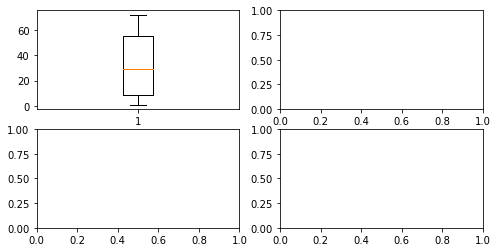

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(8, 4))

axs[0,0].boxplot(data=df_num, )
#axs[0,1].boxplot(data=df_num, x='cancelacion', y='cuenta_mensual')
#axs[1,0].boxplot(data=df_num, x='cancelacion', y='cuentas_total')
#axs[1,1].boxplot(data=df_num, x='cancelacion', y='cuentas_diarias')

### Analisis estadistico variables categoricas

Para las variables categoricas, seleccionamos los registros de los cliente que cancelan y obtenemos el conteo de cada valor.

In [ ]:
# dataframe de variables categoricas de clientes que cancelan
df_bin_1 = df_bin[df_bin['cancelacion'] == 1]
df_bin_1.head()

cancelacion  genero  jubilado  en_pareja  dependientes  \
2             1       1         0          0             0   
3             1       1         1          1             0   
4             1       0         1          1             0   
18            1       1         1          0             0   
19            1       1         1          0             0   

    servicio_telefonico  servicio_internet  seguridad_online  respaldo_online  \
2                     1                  1                 1                1   
3                     1                  1                 1                2   
4                     1                  1                 1                1   
18                    1                  1                 2                1   
19                    0                  1                 1                1   

    proteccion_dispositivo  soporte_efectivo  Streaming_TV  \
2                        2                 1             1   
3                        2                 1             2   
4                        1                 2             2   
18                       2                 1             1   
19                       1                 1             1   

    Streaming_peliculas  tipo_contrato  facturacion_electronica  \
2                     1              0                        1   
3                     2              0                        1   
4                     1              0                        1   
18                    2              1                        0   
19                    1              0                        1   

                metodo_pago  
2          Electronic check  
3          Electronic check  
4              Mailed check  
18  Credit card (automatic)  
19         Electronic check

In [ ]:
# conteo de valores de cada variable categorica
for col in df_bin_1.columns:
    print('-'*10)
    print(col)
    print(df_bin_1[col].value_counts(normalize=True))

----------
cancelacion
1    1.0
Name: cancelacion, dtype: float64
----------
genero
0    0.502408
1    0.497592
Name: genero, dtype: float64
----------
jubilado
0    0.745318
1    0.254682
Name: jubilado, dtype: float64
----------
en_pareja
0    0.642055
1    0.357945
Name: en_pareja, dtype: float64
----------
dependientes
0    0.825575
1    0.174425
Name: dependientes, dtype: float64
----------
servicio_telefonico
1    0.909042
0    0.090958
Name: servicio_telefonico, dtype: float64
----------
servicio_internet
1    0.93954
0    0.06046
Name: servicio_internet, dtype: float64
----------
seguridad_online
1    0.781701
2    0.157838
0    0.060460
Name: seguridad_online, dtype: float64
----------
respaldo_online
1    0.659711
2    0.279829
0    0.060460
Name: respaldo_online, dtype: float64
----------
proteccion_dispositivo
1    0.64794
2    0.29160
0    0.06046
Name: proteccion_dispositivo, dtype: float64
----------
soporte_efectivo
1    0.773676
2    0.165864
0    0.060460
Name: soport

> Hay 1869 clientes que cancelan el servicio con la empresa.

> Presentan similares proporciones entre hombre y mujeres.

> 74% no son jubilados.

> La mayoria son solteros (64%).

> El 82% no poseen dependientes.

> El 90% cuenta con servicio telefonico.

> El 93% cuenta con servicion de internet.

> El 78% no cuenta con seguridad en linea.

> La mayoria tampoco no cuenta con respaldo en linea (66%)

> La mayoria no esta suscrito a proteccion del dispositivo (65%)

> La mayoria no cuentan con un soporte mejorado (77%)

> La proporcion entre los que cuentan con servicio de TV por cable y los que no es muy similar. Tambien ocurre lo mismo con el servicio de streaming de peliculas.

> El 88% tienen un contrato de tipo mes a mes.

> La mayoria prefiere recibir la factura electronica.

> El metodo de pago preferido por este grupo es Cheque Electronico.



Ahora, procedemos a obtener la misma estadistica para clientes que mantienen el servicio con la empresa.

In [ ]:
# dataframe de variables categoricas de clientes que cancelan
df_bin_0 = df_bin[df_bin['cancelacion'] == 0]
df_bin_0.head()

cancelacion  genero  jubilado  en_pareja  dependientes  \
0            0       0         0          1             1   
1            0       1         0          0             0   
5            0       0         0          0             1   
6            0       0         1          1             0   
7            0       1         0          1             0   

   servicio_telefonico  servicio_internet  seguridad_online  respaldo_online  \
0                    1                  1                 1                2   
1                    1                  1                 1                1   
5                    1                  1                 1                1   
6                    1                  1                 2                2   
7                    1                  1                 2                1   

   proteccion_dispositivo  soporte_efectivo  Streaming_TV  \
0                       1                 2             2   
1                       1                 1             1   
5                       1                 2             2   
6                       2                 2             2   
7                       1                 2             1   

   Streaming_peliculas  tipo_contrato  facturacion_electronica  \
0                    1              1                        1   
1                    2              0                        0   
5                    2              0                        1   
6                    2              2                        1   
7                    1              2                        1   

                 metodo_pago  
0               Mailed check  
1               Mailed check  
5    Credit card (automatic)  
6  Bank transfer (automatic)  
7    Credit card (automatic)

In [ ]:
# conteo de valores de cada variable categorica
for col in df_bin_0.columns:
    print('-'*10)
    print(col)
    print(df_bin_0[col].value_counts(normalize=True))

----------
cancelacion
0    1.0
Name: cancelacion, dtype: float64
----------
genero
1    0.507263
0    0.492737
Name: genero, dtype: float64
----------
jubilado
0    0.871005
1    0.128995
Name: jubilado, dtype: float64
----------
en_pareja
1    0.5276
0    0.4724
Name: en_pareja, dtype: float64
----------
dependientes
0    0.656595
1    0.343405
Name: dependientes, dtype: float64
----------
servicio_telefonico
1    0.90122
0    0.09878
Name: servicio_telefonico, dtype: float64
----------
servicio_internet
1    0.727484
0    0.272516
Name: servicio_internet, dtype: float64
----------
seguridad_online
1    0.394344
2    0.333140
0    0.272516
Name: seguridad_online, dtype: float64
----------
respaldo_online
2    0.368390
1    0.359094
0    0.272516
Name: respaldo_online, dtype: float64
----------
proteccion_dispositivo
1    0.364710
2    0.362774
0    0.272516
Name: proteccion_dispositivo, dtype: float64
----------
soporte_efectivo
1    0.392408
2    0.335077
0    0.272516
Name: soporte

> La proporcion en cuanto al genero son similares.

> La mayoria no son jubilados.

> La proporcion entre solteros y en pareja son similares.

> El 65% no tiene dependientes.

> La mayoria tiene servicio telefonico (90%)

> El 72% tiene servicio de internet.

> La cantidad de clientes que no tienen seguridad en linea es ligeramente mayor de los que si tienen (39%-33%)

> La proporcion de los que tienen respaldo online de los que no es muy similar. Lo mismo ocurre para proteccion del dispositivo, Streaming TV y streaming de peliculas.

> La cantidad de clientes que no tienen soporte mejorado es ligeramente mayor de los que si tiene (39%-33%)

> La mayoria tienen un tipo de contrato mes a mes.

> El 53% prefieren factura electronica.

> La proporcion en cuanto a los metodos de pagos son muy similares.

Para entender visualmente las conclusiones obtenidas a partir de la estadistica descriptiva, vamos a crear graficos tanto para las variables numericas como para las categoricas.

### Visualizacion variables numericas

In [ ]:
df_num[df_num['cancelacion'] == 1]['meses_contrato'].median()

10.0

In [ ]:
df_num[df_num['cancelacion'] == 0]['meses_contrato'].median()

38.0

In [ ]:
cols = ['cuenta_mensual', 'cuentas_total', 'cuentas_diarias']


def resumen_estadistico(df, columnas):
    
    stats = []

    for col in columnas:
        cancelan = df[df['cancelacion'] == 1][col]
        no_cancelan = df[df['cancelacion'] == 0][col]

        stats.append(['Media', col, 'Cancelaron', cancelan.mean()])
        stats.append(['Media', col, 'No cancelaron', no_cancelan.mean()])
        stats.append(['Mediana', col, 'Cancelaron', cancelan.median()])
        stats.append(['Mediana', col, 'No cancelaron', no_cancelan.median()])

    new_df = pd.DataFrame(stats, columns=['estadistico', 'variable', 'grupo', 'valor'])
    return new_df

In [ ]:
df_resumen = resumen_estadistico(df_num, cols)

In [ ]:
df_resumen

estadistico         variable          grupo        valor
0        Media   cuenta_mensual     Cancelaron    74.441332
1        Media   cuenta_mensual  No cancelaron    61.307408
2      Mediana   cuenta_mensual     Cancelaron    79.650000
3      Mediana   cuenta_mensual  No cancelaron    64.450000
4        Media    cuentas_total     Cancelaron  1531.796094
5        Media    cuentas_total  No cancelaron  2555.344141
6      Mediana    cuentas_total     Cancelaron   703.550000
7      Mediana    cuentas_total  No cancelaron  1683.600000
8        Media  cuentas_diarias     Cancelaron     0.637061
9        Media  cuentas_diarias  No cancelaron     0.160736
10     Mediana  cuentas_diarias     Cancelaron     0.249306
11     Mediana  cuentas_diarias  No cancelaron     0.055444